Test with Self-Attention model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install neptune
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 KB 4.5 MB/s eta 0:00:00
Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (128/128), done.
remote:

---

In [3]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [4]:
import os 
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
import neptune

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss


from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.models.ts_transformer import RelativeGlobalAttention
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# from src.running import train_step1, eval_step1

<ipython-input-4-9aed3ac8f118>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

In [6]:
# setup model configurations
config = {
    # general information
    "experiment-name": "Experiment_section-1", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "Self-Attention",
    "sem-space": 'I3D embeddings',
    # model training configs
    "lr": 0.0001,
    "imu_alpha": 0.0001,
    "n_epochs": 20,
    "batch_size": 64,
    # model configs
    "d_model": 256, 
    "num_heads": 2,
    "feat_size": 400, # skel-AE hidden size and IMU-Anc output size
    # dataset configs
    "window_size": 5.21, 
    "overlap": 4.21,
    "seq_len": 10,  # skeleton seq. length
    "seen_split": 0.1,
    "unseen_split": 0.8
}

In [7]:
def save_model(model,model_name,unique_name,fold_id):
    PATH = f"{models_saves}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}_{fold_id}.pt")

model_iden = "fold"
notebook_iden = "SORTModel_feature"
models_saves = "model_saves"

In [8]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = PAMAP2ReaderV2(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:1275: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [9]:
def read_I3D_pkl(loc,feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    all_arr = np.asarray(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.asarray(label)
  prototype = np.array(prototype)
  return {"activity":label, "features":prototype}

In [10]:
# load video dataset
I3D_data_path  = data_root + '/I3D/video_feat.pkl'
video_data = read_I3D_pkl(I3D_data_path,feat_size="400")
video_classes, video_feat = video_data['activity'], video_data['features']

In [11]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        vid_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[vid_idx, ...]
        return x, y, y_feat

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = []
        for c in self.action_classes:
            idx = self.attribute_dict[c]
            cls_feat.append(torch.mean(self.attributes[idx, ...], dim=0))

        cls_feat = torch.vstack(cls_feat)
        # print(cls_feat.size())
        return cls_feat

In [24]:
class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, n_classes, max_len=1024, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)
        # positional encoding concat <-> 1DConv 
        self.Act = F.relu  # _get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)
        self.logist = nn.Linear(self.ft_size, self.n_classes)
        self.DenseL3 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        out = self.Act(out)
        out = self.AvgPoolL(out)
        out = torch.squeeze(out)
        out = self.dropout(out)
        out = self.DenseL2(out)   
        # out = self.DenseL3(out)
        # out = self.logist(out1)     
        return out

In [25]:
model = IMUEncoder(in_ft=54, d_model=128, ft_size=64, n_classes=18, num_heads=2, max_len=1024, dropout=0.1)

In [26]:
input_tensor = torch.rand((32, 27, 54))
output_tensor = model(input_tensor)
output_tensor.shape

RuntimeError: ignored

---

In [13]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [15]:
def selecting_video_prototypes(prototypes:np.array,classes:np.array,vid_class_name:np.array):
    selected = []
    for tar in vid_class_name:
        indexes = np.where(classes == tar)
        selected.append(torch.from_numpy(prototypes[random.choice(indexes[0])]))

    return torch.stack(selected)

In [16]:
label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(video_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [17]:
def loss_cross_entropy(y_pred, y, feat, loss_fn):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    output = loss_fn(softmax_vec, y)
    pred = torch.argmax(softmax_vec, dim=-1)
    return output, pred

def loss_reconstruction_calc(y_pred, y_feat, loss_fn=nn.L1Loss(reduction="sum")):
    loss = loss_fn(y_pred,y_feat)
    return loss

def predict_class(y_pred, feat):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    pred = torch.argmax(softmax_vec, dim=-1)
    return pred

In [18]:
def train_step(model, dataloader, dataset:PAMAP2Dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [19]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat = batch
            X = X.float().to(device)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])
            
            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [20]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

In [21]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

In [22]:
run = neptune.init_run(
    project="FYP-Group22/ICANN-Logs",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

<ipython-input-22-0fd58e113600>:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/FYP-Group22/ICANN-Logs/e/IC-176


================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.366



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.449



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.550



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.605



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.633



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.685



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.735



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.781



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.819



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.863



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.884



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.893



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.907



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.921



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.917



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.929



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.929



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.935



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.934



train:   0%|          | 0/142 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.935



unseen:   0%|          | 0/42 [00:00<?, ?batch/s]

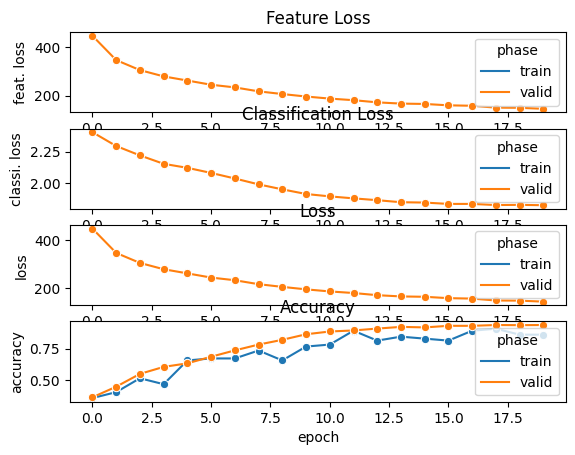

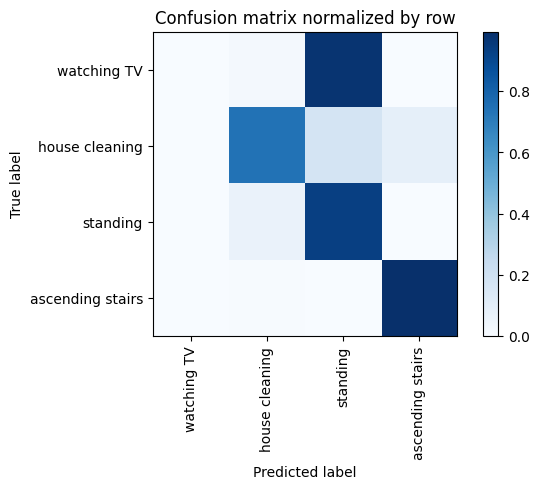

Overall accuracy: 0.737

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  house cleaning       0.908      0.741      0.816      0.336        903|	 standing: 0.173,	ascending stairs: 0.086,	
        standing       0.600      0.935      0.731      0.333        895|	 house cleaning: 0.063,	watching TV: 0.002,	
ascending stairs       0.859      0.994      0.922      0.178        479|	 house cleaning: 0.006,	standing: 0.000,	
     watching TV       0.000      0.000      0.000      0.153        411|	 standing: 0.978,	house cleaning: 0.022,	ascending stairs: 0.000,	

----------------------------------------------------------------------------------------------------
     avg / total       0.658      0.737      0.682        1.0       2688|	      

{'accuracy': 0.7373511904761905, 'precision': 0.5917349582902685, 'recall': 0.6674490675212427, 'f1': 0.6171114085637277, 'samples': 2688, 'loss': 1098027.732421875, 'feat. loss': 1098027.482421875, 'class

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.291



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.556



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.639



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.661



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.715



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.727



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.744



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.760



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.780



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.800



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.826



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.834



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.848



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.859



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.869



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.870



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.876



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.887



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.887



train:   0%|          | 0/143 [00:00<?, ?batch/s]

seen:   0%|          | 0/15 [00:00<?, ?batch/s]

Overall accuracy: 0.887



unseen:   0%|          | 0/41 [00:00<?, ?batch/s]

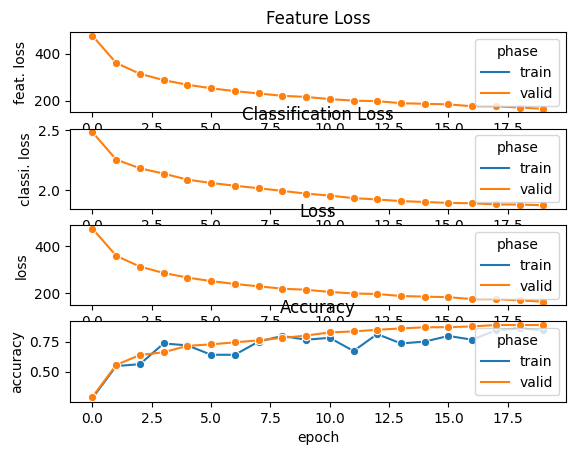

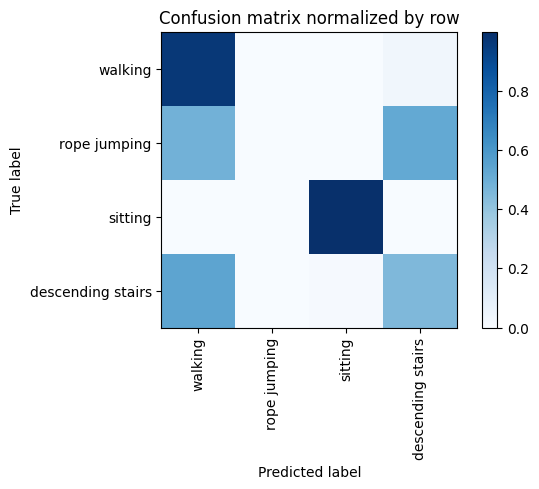

Overall accuracy: 0.818

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.772      0.966      0.858      0.432       1133|	 descending stairs: 0.034,	sitting: 0.000,	
          sitting       0.995      0.999      0.997      0.331        869|	 descending stairs: 0.001,	rope jumping: 0.000,	
descending stairs       0.554      0.449      0.496      0.157        412|	 walking: 0.541,	sitting: 0.010,	
     rope jumping       0.000      0.000      0.000      0.080        210|	 descending stairs: 0.519,	walking: 0.481,	sitting: 0.000,	

----------------------------------------------------------------------------------------------------
      avg / total       0.750      0.818      0.778        1.0       2624|	      

{'accuracy': 0.8182164634146342, 'precision': 0.5802035568618976, 'recall': 0.6033641223591452, 'f1': 0.5877023753019649, 'samples': 2624, 'loss': 1016576.5859375, 'feat. loss': 1016576.345703125, 'classi. loss

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.201



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.298



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.377



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.527



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.603



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.640



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.676



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.731



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.754



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.780



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.797



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.801



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.844



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.850



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.865



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.882



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.895



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.898



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.906



train:   0%|          | 0/131 [00:00<?, ?batch/s]

seen:   0%|          | 0/14 [00:00<?, ?batch/s]

Overall accuracy: 0.911



unseen:   0%|          | 0/54 [00:00<?, ?batch/s]

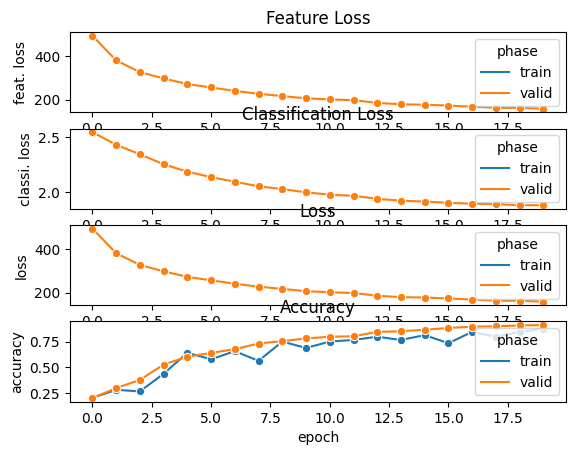

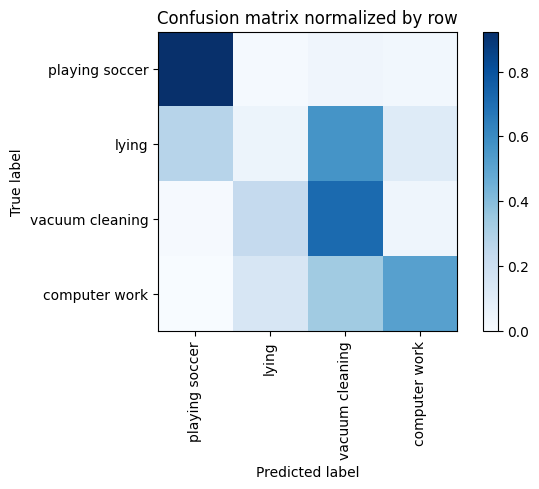

Overall accuracy: 0.467

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.845      0.516      0.641      0.437       1509|	 vacuum cleaning: 0.335,	lying: 0.148,	
          lying       0.095      0.049      0.064      0.262        905|	 vacuum cleaning: 0.568,	playing soccer: 0.271,	computer work: 0.113,	
vacuum cleaning       0.364      0.715      0.482      0.238        822|	 lying: 0.234,	computer work: 0.043,	
 playing soccer       0.446      0.923      0.601      0.064        220|	 vacuum cleaning: 0.036,	computer work: 0.027,	

----------------------------------------------------------------------------------------------------
    avg / total       0.509      0.467      0.450        1.0       3456|	      

{'accuracy': 0.4670138888888889, 'precision': 0.437487503954451, 'recall': 0.5507276105593297, 'f1': 0.4472650205979561, 'samples': 3456, 'loss': 1913731.59765625, 'feat. loss': 1913731.17578125, 'classi. loss': 

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.204



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.375



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.474



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.591



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.653



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.699



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.720



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.740



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.751



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.763



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.770



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.778



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.793



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.823



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.835



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.854



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.857



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.861



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.881



train:   0%|          | 0/150 [00:00<?, ?batch/s]

seen:   0%|          | 0/16 [00:00<?, ?batch/s]

Overall accuracy: 0.872



unseen:   0%|          | 0/33 [00:00<?, ?batch/s]

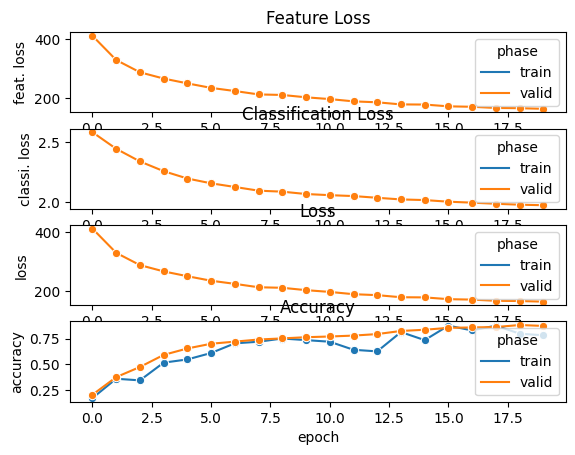

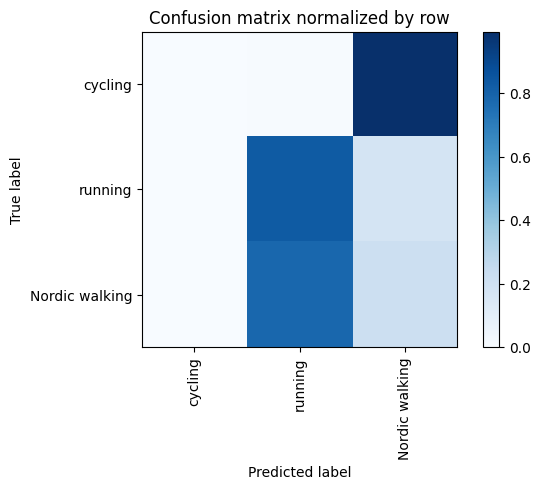

Overall accuracy: 0.268

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.186      0.217      0.200      0.421        890|	 running: 0.783,	cycling: 0.000,	
       cycling       0.000      0.000      0.000      0.366        772|	 Nordic walking: 0.994,	running: 0.006,	
       running       0.346      0.827      0.488      0.213        450|	 Nordic walking: 0.173,	cycling: 0.000,	

----------------------------------------------------------------------------------------------------
   avg / total       0.152      0.268      0.188        1.0       2112|	      

{'accuracy': 0.2675189393939394, 'precision': 0.1774344014954988, 'recall': 0.34784019975031216, 'f1': 0.2294654817525403, 'samples': 2112, 'loss': 1242875.97265625, 'feat. loss': 1242875.71484375, 'classi. loss': 2461.5646057128906, 'N': 3}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']
seen classes >  [0, 1, 2,

Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.175



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.394



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.460



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.533



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.574



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.648



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.687



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.714



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.752



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.768



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.811



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.850



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.869



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.881



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.892



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.903



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.901



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.916



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.922



train:   0%|          | 0/153 [00:00<?, ?batch/s]

seen:   0%|          | 0/17 [00:00<?, ?batch/s]

Overall accuracy: 0.926



unseen:   0%|          | 0/29 [00:00<?, ?batch/s]

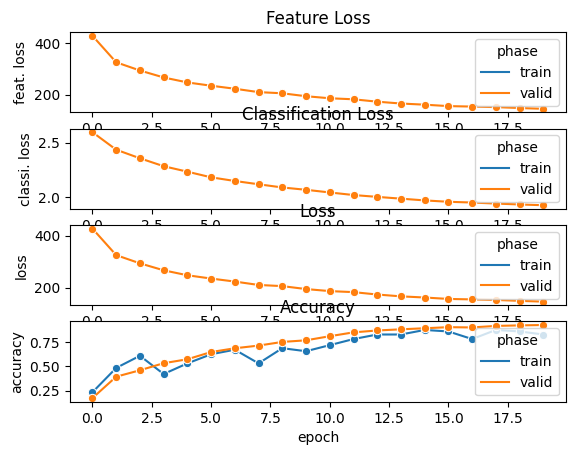

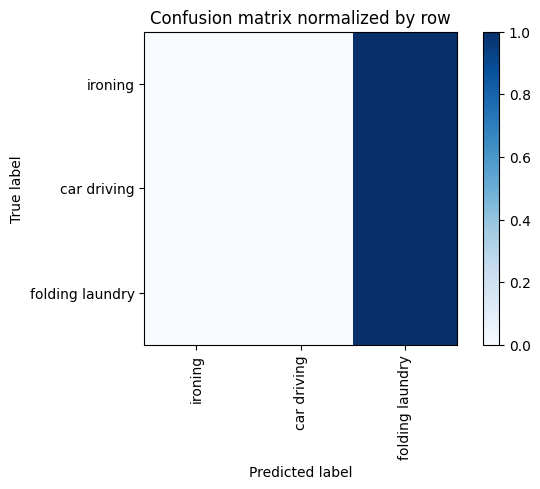

Overall accuracy: 0.249

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.000      0.000      0.000      0.607       1127|	 folding laundry: 1.000,	car driving: 0.000,	
folding laundry       0.249      1.000      0.399      0.249        463|	 car driving: 0.000,	ironing: 0.000,	
    car driving       0.000      0.000      0.000      0.143        266|	 folding laundry: 1.000,	ironing: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.062      0.249      0.100 0.9999999999999999       1856|	      

{'accuracy': 0.2494612068965517, 'precision': 0.08315373563218391, 'recall': 0.3333333333333333, 'f1': 0.1331033491447463, 'samples': 1856, 'loss': 1215114.47265625, 'feat. loss': 1215114.24609375, 'classi. loss': 2408.1989364624023, 'N': 3}
============== Overall Unseen Classes Performance ==============
accuracy     0.535626
precision    0.4010

In [25]:
run['parameters'] = config
fold_metric_scores = []

for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=12, window_overlap=10, resample_freq=50)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=video_feat, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    imu_config = {
        'in_ft':in_ft, 
        'd_model':config['d_model'], 
        'num_heads':config['num_heads'], 
        'ft_size':config['feat_size'], 
        'max_len':seq_len, 
        'n_classes':len(seen_classes)
    }
    model = IMUEncoder(**imu_config)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-6)
    loss_module = {'class': nn.CrossEntropyLoss(reduction="sum"), 'feature': nn.L1Loss(reduction="sum")}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
    
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        log(i, 'train', train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, print_report=False, show_plot=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        log(i, 'eval', eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001, print_report=True, show_plot=True)
    test_metrics['N'] = len(unseen_classes)
    fold_metric_scores.append(test_metrics)
    log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
weighted_score_df = seen_score_df[["accuracy", "precision", "recall", "f1"]].multiply(seen_score_df["N"], axis="index")
final_results = weighted_score_df.sum()/seen_score_df['N'].sum()
print(final_results)
log('global', '',final_results.to_dict())
run.stop()
